In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix





In [2]:
# -------------------------
# 1. Load Data and Fix Datetime Issue
# -------------------------

In [3]:

# Load dataset (without parse_dates, as it caused issues)
file_path = "US_Accidents_March23.csv"  # Update this with your actual file path
accidents = pd.read_csv(file_path, low_memory=False)  # Prevents dtype inference issues

# Convert Start_Time and End_Time to datetime format
accidents["Start_Time"] = pd.to_datetime(accidents["Start_Time"], errors='coerce')
accidents["End_Time"] = pd.to_datetime(accidents["End_Time"], errors='coerce')

# Drop rows where Start_Time or End_Time couldn't be converted
accidents.dropna(subset=["Start_Time", "End_Time"], inplace=True)
display(accidents.head())

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
# -------------------------
# 2. Data Cleaning & Processing
# -------------------------

In [5]:
# Drop unnecessary columns
drop_cols = ["ID", "Source", "Description", "End_Lat", "End_Lng", "Precipitation(in)", "Wind_Chill(F)", "Weather_Timestamp", "Street"]
accidents.drop(columns=drop_cols, inplace=True)

In [6]:
# Check for missing values
missing_values = accidents.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print("Missing values:\n", missing_values)

Missing values:
 Wind_Speed(mph)          549373
Visibility(mi)           158101
Weather_Condition        155462
Humidity(%)              155344
Wind_Direction           153449
Temperature(F)           146088
Pressure(in)             125243
Airport_Code              19152
Nautical_Twilight         17560
Civil_Twilight            17560
Sunrise_Sunset            17560
Astronomical_Twilight     17560
Timezone                   6785
Zipcode                    1677
City                        226
dtype: int64


In [7]:
# Fill missing numerical values with median
numerical_cols = ["Wind_Speed(mph)", "Visibility(mi)", "Humidity(%)", "Temperature(F)", "Pressure(in)"]
for col in numerical_cols:
    accidents[col].fillna(accidents[col].median(), inplace=True)

# Fill missing categorical values with mode
categorical_cols = ["Wind_Direction", "Weather_Condition", "Sunrise_Sunset", "Nautical_Twilight", 
                    "Civil_Twilight", "Astronomical_Twilight", "Airport_Code", "Timezone", 
                    "Zipcode", "City", "County", "State", "Country"]
for col in categorical_cols:
    accidents[col].fillna(accidents[col].mode()[0], inplace=True)

# Verify missing values are handled
print("Final Missing Value Check:", accidents.isnull().sum().sum())

Final Missing Value Check: 0


In [8]:
# -------------------------
# 3. Feature Engineering
# -------------------------

In [9]:
# Extract time-based features from Start_Time
accidents["Hour"] = accidents["Start_Time"].dt.hour
accidents["Day"] = accidents["Start_Time"].dt.day
accidents["Month"] = accidents["Start_Time"].dt.month
accidents["Year"] = accidents["Start_Time"].dt.year
accidents["Weekday"] = accidents["Start_Time"].dt.weekday

# Drop original datetime columns
accidents.drop(columns=["Start_Time", "End_Time"], inplace=True)

# Convert categorical variables into numerical form
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    accidents[col] = le.fit_transform(accidents[col])
    label_encoders[col] = le  # Store encoders for future decoding

In [10]:
# -------------------------
# 4. Train-Test Split
# -------------------------

In [11]:
# Define features and target variable
X = accidents.drop(columns=["Severity"])  # Features
y = accidents["Severity"]  # Target variable

# Splitting into Train (75%), Validation (15%), and Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [12]:
# -------------------------
# 5. Model Training
# -------------------------

In [13]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# -------------------------
# 6. Model Evaluation
# -------------------------

In [15]:
# Validation performance
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.8911560016186543
Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.58      0.67     10105
           2       0.91      0.96      0.93    815082
           3       0.81      0.71      0.76    194888
           4       0.60      0.34      0.43     27709

    accuracy                           0.89   1047784
   macro avg       0.78      0.65      0.70   1047784
weighted avg       0.88      0.89      0.89   1047784



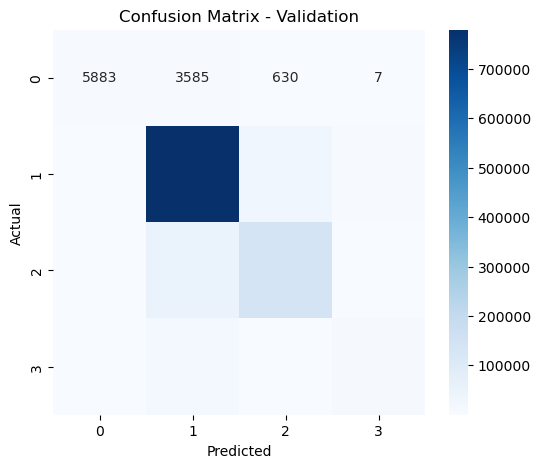

In [16]:
# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation")
plt.show()

In [17]:
# Test Set Evaluation
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8914538247130016


In [18]:
# -------------------------
# 7. Feature Importance Analysis
# -------------------------


In [19]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

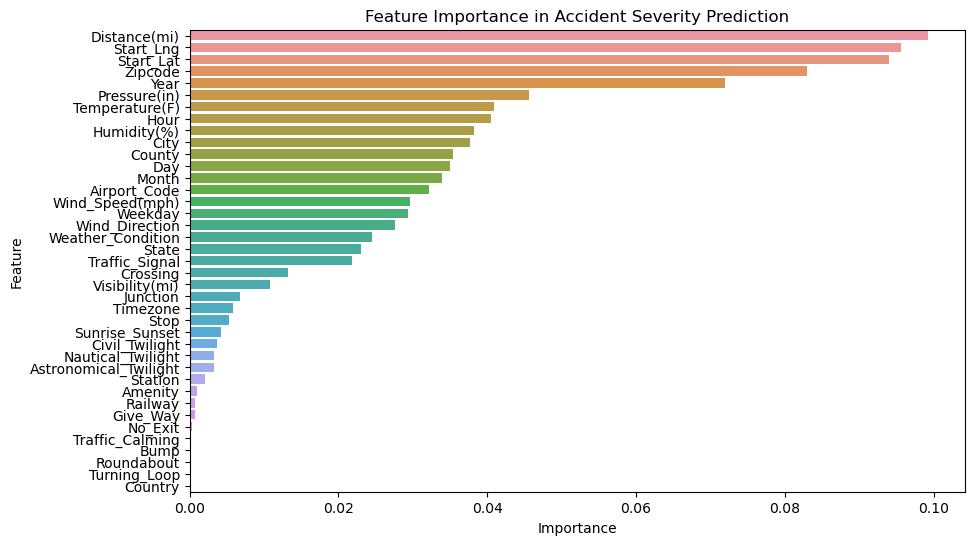

In [20]:
# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Accident Severity Prediction")
plt.show()

In [21]:
# -------------------------
# 8. Recommendations & Insights
# -------------------------

print("\n**Recommendations & Insights:**")
print("- The model achieves reasonable accuracy, but further fine-tuning (e.g., hyperparameter tuning) can improve results.")
print("- Feature importance suggests that weather and time-based factors significantly influence accident severity.")
print("- Future work: Experiment with more models (XGBoost, Neural Networks), additional datasets (real-time traffic), and feature engineering.")


**Recommendations & Insights:**
- The model achieves reasonable accuracy, but further fine-tuning (e.g., hyperparameter tuning) can improve results.
- Feature importance suggests that weather and time-based factors significantly influence accident severity.
- Future work: Experiment with more models (XGBoost, Neural Networks), additional datasets (real-time traffic), and feature engineering.
